# Segmentez des clients d'un site e-commerce
## Notebook 4 : Simulation d'un contrat de maintenance
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Présentation du projet

**Contexte**  


* Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.  
* Dans un premier temps il est demandé de réaliser quelques requêtes pour le dashboard à partir de la base de données SQLite d'Olist.  
* La mission principale est de fournir aux équipes d'e-commerce d'Olist une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.
* Cette mission se concluera par la simulation d'un contrat de maintenance.

**Démarche globale**  
* Requêtes SQL pour le dashboard (cf Notebook 1)  
* Feature ingineering (cf Notebook 2)
* Tests de modèles de clustering : (cf Notebook 3)  
* **Simulation d'un contrat de maintenance** : c'est l'objet de ce notebook 4  

**Simulation d'un contrat de maintenance**  
* Objectif : déterminer au bout de combien de temps le modèle retenu doit être réentrainé  
* Démarche :
  * Comparer les résultats du dernier clustering réalisé (fin août 2018) avec les prédictions d'un modèle entrainé X jours avant  
  * La comparaison sera mesurée par le score ARI (Adjusted Rand Index) qui mesure la divergence entre clusters  
  * Si les score obtenu est supérieur à 0.80, considérer que les prédictions sont suffisament fiables et retester avec les prédictions d'un modèle entraîné X jours avant
  * Le délai avant de devoir réentraîner le modèle sera déterminé dès que le score ARI sera descendu sous le seuil de 0.80

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions

**Stratégie**  

**Chargement des données**  

**Calcul des scores ARI**  
* Récupération des Labels D1 (réel)
* Récupération des Labels D1 (simulation) et calcul des scores ARI
* Visualisation

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('pandas')
install_package('scikit-learn')
install_package('matplotlib')

pandas est déjà installé.
scikit-learn est déjà installé.
matplotlib est déjà installé.


* Import des modules

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## 1.3 Fonctions

In [5]:
def get_RFM_features(df, end_date):
    """
    Renvoie un dataframe contenant une ligne par client ayant commandé avant 'end_date' ainsi que les features :
        - 'Récence'   : nombre de jours depuis la dernière commande
        - 'Fréquence' : 0 si le client a passé une seule commande, 1 s'il en a passé plusieurs
        - 'Montant'   : total des montants des commandes du client

    Parameters:
        df (pandas.DataFrame)      : DataFrame de features
        end_date (pandas.datetime) : Date de fin (filtre)

    Returns:
        df_data (pandas.DataFrame) : DataFrame avec features RFM
    """
    # Filtre sur la date de fin
    mask = df['order_purchase_timestamp'] < end_date
    
    # Dernière date de commande
    last_purchase_date = df.loc[mask, 'order_purchase_timestamp'].max()
    
    
    # Préparation du dataframe
    df_data = df.loc[mask].groupby('customer_unique_id').agg(
        Récence = ('order_purchase_timestamp', 'max'),
        Fréquence = ('customer_id', 'count'),
        Montant = ('total_price', 'sum')
    ).reset_index()
    
    # Récence
    df_data['Récence'] = (last_purchase_date - df_data['Récence']).dt.days

    # Fréquence
    mask = df_data['Fréquence'] > 1
    df_data['Fréquence'] = 0
    df_data.loc[mask, 'Fréquence'] = 1

    return df_data

In [6]:
def add_transformed_RFM_features(df, recence_t=MinMaxScaler(), montant_t=MinMaxScaler()):
    """
    Ajoute les features RFM transformées à df et renvoit les transformers utilisés

    Parameters:
        df (array-like)                 : Données
        recence_t (sklearn.transformer) : Tarnsformer à appliquer à la feature Récence
        montant_t (sklearn.transformer) : Tarnsformer à appliquer à la feature Montant
        
    Returns:
        df (array-like)                 : Données
        recence_t (sklearn.transformer) : Transformer appliqué à la feature Récence
        montant_t (sklearn.transformer) : Transformer appliqué à la feature Montant
    
    """
    # Récence
    recence_transformer = recence_t.fit(df[['Récence']])
    df['Récence_minmax'] = recence_transformer.transform(df[['Récence']])

    # Fréquence (valeurs déjà comprise entre 0 et 1)
    df['Fréquence_minmax'] = df['Fréquence']

    # Classement par intervalles de montants
    bins = [0, 25, 50, 100, 150, 200, 250, 500, 1000, float('inf')]
    labels = range(len(bins) - 1)
    df['Montant_class'] = pd.cut(df['Montant'], bins=bins, labels=labels, right=False)
    montant_transformer = montant_t.fit(df[['Montant_class']])
    df['Montant_class_minmax'] = montant_transformer.transform(df[['Montant_class']])

    return df, recence_transformer, montant_transformer

# 2 Stratégie

Simuler un contrat de maintenance, c’est **déterminer combien de temps le modèle entraîné peut rester performant.**  

* **Comment déterminer cette "performance" ?**  
   * Si on entraîne un modèle à la date D0 et qu’on utilise ce modèle entraîné pour prédire les segmentations à la date D1, il est possible de comparer ces prédictions avec la réalité, en réentraînant le modèle à la date D1.  
   * Pour disposer du clustering réel en D1, il suffit de se positionner en D1, et de simuler une prédiction antérieure en D0, sur les données de D1.  
   * On pourra donc comparer :  
      * `modele_D0.predict(datas_D1).labels_` vs `model_D1.fit(datas_D1).labels_`
      * avec `modele_D0 = KMeans(k=6).fit(datas_D0)`  
   * Attention au fait que les datas_D0 sont en fait des données mises à l’échelle via `MinMaxScaler()`. Il faudra réutiliser la même instance de ce transformer sur les datas_D1 avant le predict pour obtenir une mise à l’échelle cohérente.  

* **Comment mesurer l’efficacité des prédictions ?**  
   * SciKit-learn fournit la méthode `adjusted_rand_score()` qui mesure la divergence entre une liste de labels de clusters prédits et une liste de labels de clusters réels.  
   * Cet indice est proche de 0 pour un clustering aléatoire, négatif pour un clustering particulièrement divergent, et est égal à 1 pour une prédiction parfaite.  
   * Le score de **0.8** sera retenu comme seuil pour un clustering suffisamment efficace pour ne pas nécessiter de réentraîner le modèle.  

# 3 Chargement des données

* Lors de l'étape de feature ingineering (Notebook 2), un dasaset contenant une ligne par commande, avant transformation des features RFM a été préparé

In [7]:
# Chargement du dataset
df_features = pd.read_csv('df_data.csv')

In [8]:
# Affichage de quelques lignes
display(df_features)

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,total_price,satisfaction,year_month
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,146.87,4.0,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,29150127e6685892b6eab3eec79f59c7,2018-01-12,335.48,5.0,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,157.73,5.0,2018-05
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,951670f92359f4fe4a63112aa7306eba,2018-03-13,173.30,5.0,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29,252.25,5.0,2018-07
...,...,...,...,...,...,...,...
97900,1a29b476fee25c95fbafc67c5ac95cf8,17ddf5dd5d51696bb3d7c6291687be6f,6760e20addcf0121e9d58f2f1ff14298,2018-04-07,88.78,4.0,2018-04
97901,d52a67c98be1cf6a5c84435bd38d095d,e7b71a9017aa05c9a7fd292d714858e8,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04,129.06,5.0,2018-04
97902,e9f50caf99f032f0bf3c55141f019d99,5e28dfe12db7fb50a4b2f691faecea5e,fed4434add09a6f332ea398efd656a5c,2018-04-08,56.04,1.0,2018-04
97903,73c2643a0a458b49f58cea58833b192e,56b18e2166679b8a959d72dd06da27f9,e31ec91cea1ecf97797787471f98a8c2,2017-11-03,711.07,5.0,2017-11


In [9]:
# Nombre de clients : doit être égal à 94703 (cf Notebook 2)
display(df_features['customer_unique_id'].nunique())

94703

In [10]:
# Affichage des types de données
df_features.dtypes.reset_index()

,index,0
0,customer_unique_id,object
1,customer_id,object
2,order_id,object
3,order_purchase_timestamp,object
4,total_price,float64
5,satisfaction,float64
6,year_month,object


* Le type de données de la variable `order_purchase_timestamp` doit être transformé en type 'date'

In [11]:
# Conversion de la date d'achat au format datetime "YYYY-MM-DD 00:00:00"
df_features['order_purchase_timestamp'] = pd.to_datetime(df_features['order_purchase_timestamp']).dt.normalize()

# 4 Calcul des scores ARI - version présentée en soutenance

In [12]:
# Fréquence des simulations = 7 jours
simul_frequency = pd.to_timedelta('7 Days')

In [13]:
features = ['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']

## 4.1 Récupération des Labels D1 (Réel)

* On est en fin de période et on réalise un `fit_transform` pour réaliser une segmentation
* Les labels de clusters récupérés serviront de points de comparaison avec les simulations

In [14]:
# Date D1
d1_date = pd.to_datetime('2018-09-02')

* Calcul des features RFM en fonction de la date

In [15]:
d1_RFM_features = get_RFM_features(df_features, d1_date)

* Transformations des features (classement des dépenses par tranches de montant, application des transformers MinMaxScaler)

In [16]:
d1_RFM_transformed_features, _, _ = add_transformed_RFM_features(d1_RFM_features)

* Fit du modèle KMeans et récupérations des labels de clusters

In [17]:
d1_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
# d1_kmeans.fit(d1_RFM_transformed_features[features])
d1_RFM_features['R-Labels'] = d1_kmeans.fit(d1_RFM_transformed_features[features]).labels_

## 4.2 Récupération des Labels D1 (Simulation) et calculs des scores ARI

* On se place 7 jours avant et on simule une prédiction avec un modèle entrainé en D0, sur les données D1

In [18]:
# Date de première simulation
d0_date = d1_date - simul_frequency

# Stockage des résultats ARI
ari_scores = []

In [19]:
# Boucle sur les 52 dernière semaines (1 an)
for i in range(52):
    # Calcul des features RFM en fonction de la date de simulation
    d0_RFM_features = get_RFM_features(df_features, d0_date)

    # Transformation des features et résupération des transformers utilisés
    d0_RFM_transformed_features, recence_transformer, montant_transformer = add_transformed_RFM_features(d0_RFM_features)

    # Fit KMeans à la date de la simulation
    d0_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
    d0_kmeans.fit(d0_RFM_transformed_features[features])
    
    #--------------------

    # Applications des transformers D0 aux données D1
    d1_RFM_transformed_features_simul, _, _ = add_transformed_RFM_features(d1_RFM_features) #, recence_transformer, montant_transformer)

    # Predict des labels sur les données D1 avec le modèle entraîné en D0
    d1_RFM_features['P-Labels'] = d0_kmeans.predict(d1_RFM_transformed_features_simul[features])

    # Calcul du score ARI entre labels prédits en D0 à partir des données D1, et labels obtenus en D1 sur données D1 (réel)
    ari_score = adjusted_rand_score(d1_RFM_features['P-Labels'], d1_RFM_features['R-Labels'])

    # Ajout des résultats à la listes des scores ARI
    ari_scores.append((d0_date.strftime('%d-%m-%Y'), ari_score))

    # Préparation de la simulation suivante en reculant D0 d'une semaine
    d0_date -= simul_frequency

* Conversion en DataFrame et inversion de l'ordre des lignes

In [20]:
df_ari_scores = pd.DataFrame(ari_scores, columns=['Date simulation', 'Score ARI'])
df_ari_scores = df_ari_scores.sort_index(axis=0, ascending=False)

## 4.3 Visualisation

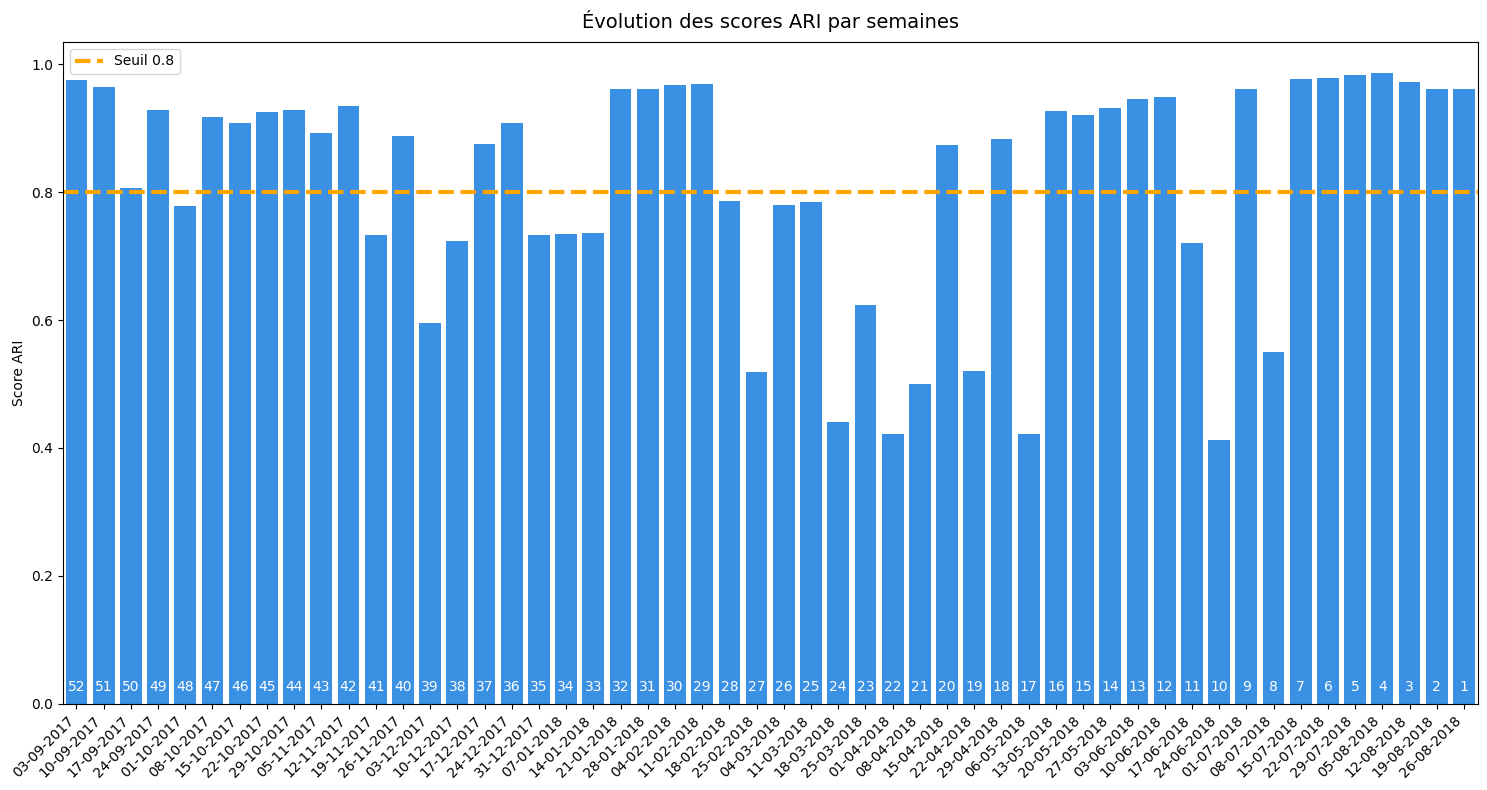

In [21]:
# Affichage d'un graphique en barres
plt.figure(figsize=(15, 8))
sns.barplot(x=df_ari_scores['Date simulation'], y=df_ari_scores['Score ARI'], color='dodgerblue')

# Ligne à 0.80
plt.axhline(y=0.8, color='orange', linestyle='--', label='Seuil 0.8', linewidth=3)
plt.xticks(rotation=45, ha='right')

# Ajout des nombres de semaines en bas des barres
for index, value in enumerate(df_ari_scores['Score ARI']):
    plt.text(x=index, y=0.02, s=f'{len(df_ari_scores) - index}', ha='center', c='white')

plt.title('Évolution des scores ARI par semaines', fontsize=14, pad=10)
plt.xlabel('')
plt.ylabel('Score ARI')
plt.legend()
plt.tight_layout()

plt.show()

# 5 Calcul des scores ARI - Version 2

* On part d'une labellisation KMeans avec des données jusqu'à D0 = 31/12/2017  
* On calcule les scores ARI entre **model_d0 / transformers dn / données dn** et **model_dn / tranformers dn / données dn**, avec dn+1 = dn + 7 jours, de d0 = 31/12/2017 jusqu'à dn < 01/09/2018
* Dans cette version les transformers sont réinitialisés à la date des données  

In [22]:
# Fréquence des simulations = 7 jours
simul_frequency = pd.to_timedelta('7 days')

In [23]:
features = ['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']

## 5.1 Modèle D0 (Réel)

* On se positionne le 31/12/2017
* On entraine un modèle et on va rechercher combien de semaines ses prédictions sont fiables (score ARI > 0.8)

In [24]:
# Date D0
d0_date = pd.to_datetime('2017-12-31')

* Calcul des features RFM en fonction de la date

In [25]:
d0_RFM_features = get_RFM_features(df_features, d0_date)

* Transformations des features (classement des dépenses par tranches de montant, application des transformers MinMaxScaler)

In [26]:
d0_RFM_transformed_features, _, _ = add_transformed_RFM_features(d0_RFM_features)

* Fit et sauvegarde du modèle KMeans

In [27]:
d0_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
d0_kmeans_fitted = d0_kmeans.fit(d0_RFM_transformed_features[features])

## 5.2 Calcul des scores ARI entre d0_kmeans.predict(d(n)_RFM_features) et d(n)_kmeans.fit(d(n)_RFM_features), avec d(n + 1) = d(n) + 7 jours 

* Boucle sur toutes les semaines suivant d0_date jusqu'au 31/08/2018 pour récupérer les labels de prédictions
* On calcule et stocke le score ARI en entre d0.predict et dn.fit

In [28]:
d_end_date = pd.to_datetime('2018-09-01')

In [29]:
# Stockage des résultats ARI
ari_scores = []

In [30]:
# Date de filtrage des données pour la première prédiction
# En fixant la première date de prédiction à la date d0, on doit trouver un score ARI de 1 pour la première prédiction
dn_date = d0_date

# Boucle jusqu'à la fin de période
while dn_date < d_end_date:
    # Calcul des features RFM en fonction de la date des données de prédiction
    dn_RFM_features = get_RFM_features(df_features, dn_date)

    # Transformation des features avec réinitialisation des transformers
    dn_RFM_transformed_features, _, _ = add_transformed_RFM_features(dn_RFM_features)

    # Récupération des labels à la date dn_date
    dn_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
    dn_kmeans.fit(dn_RFM_transformed_features[features])
    dn_RFM_features['Labels dn'] = dn_kmeans.labels_
    
    #--------------------

    # Predict des labels sur les données dn_date avec le modèle entraîné en d0_date
    dn_RFM_features['Labels d0'] = d0_kmeans.predict(dn_RFM_transformed_features[features])

    # Calcul du score ARI
    ari_score = adjusted_rand_score(dn_RFM_features['Labels d0'], dn_RFM_features['Labels dn'])

    # Ajout des résultats à la listes des scores ARI
    ari_scores.append((dn_date.strftime('%d-%m-%Y'), ari_score))

    # Préparation de la simulation suivante en décalant dn_date d'1 semaine
    dn_date += simul_frequency

* Conversion en DataFrame

In [31]:
df_ari_scores = pd.DataFrame(ari_scores, columns=['Date simulation', 'Score ARI'])

* Affichage des résultats

In [32]:
display(df_ari_scores)

,Date simulation,Score ARI
0,31-12-2017,1.000000
1,07-01-2018,0.991896
2,14-01-2018,0.988122
3,21-01-2018,0.757095
4,28-01-2018,0.764628
5,04-02-2018,0.756842
6,11-02-2018,0.762808
7,18-02-2018,0.944488
8,25-02-2018,0.500742
9,04-03-2018,0.928653


* Dès la 3ème semaine le score ARI descend en dessous de 0.8

## 5.3 Visualisation

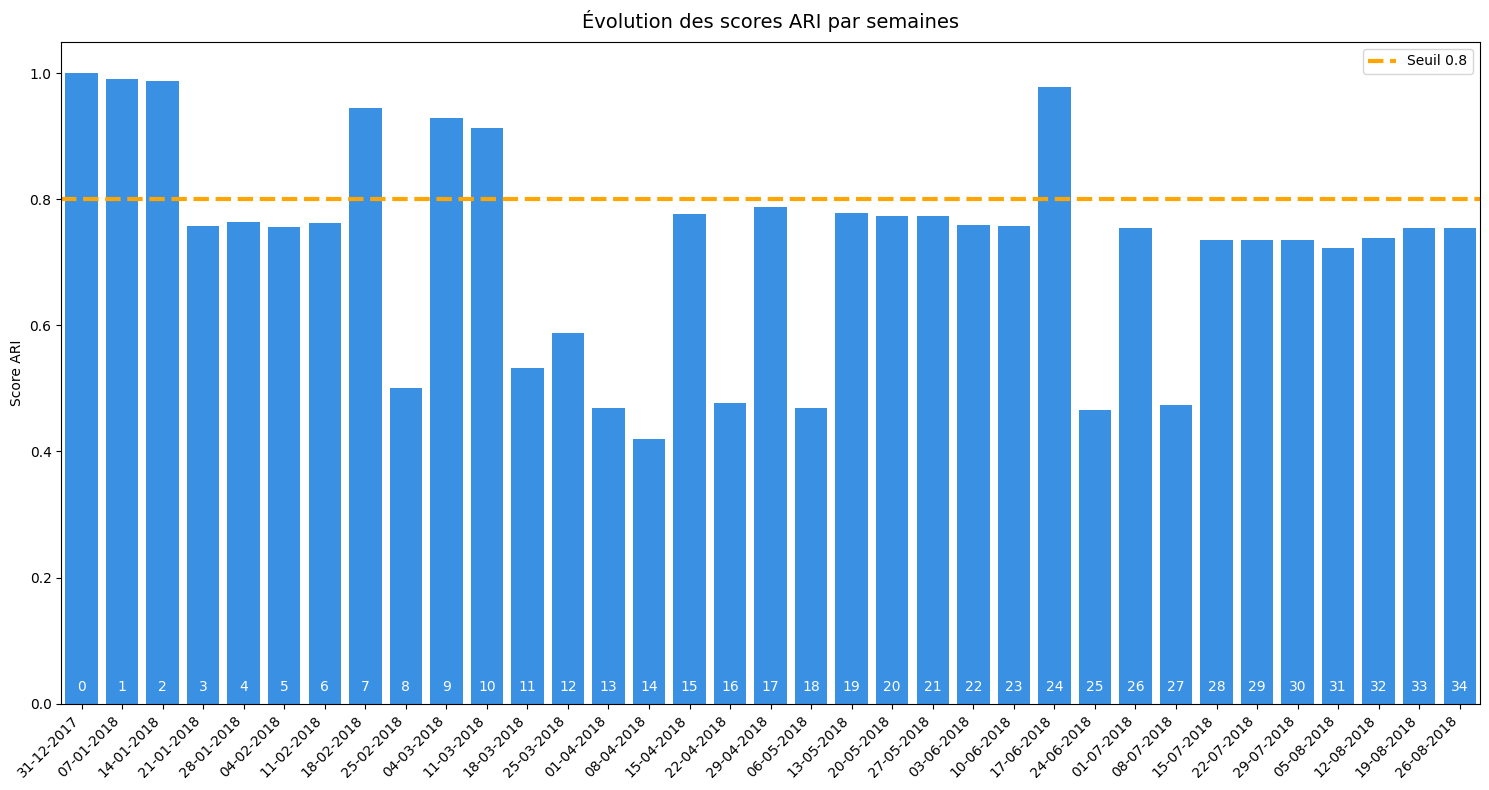

In [33]:
# Affichage d'un graphique en barres
plt.figure(figsize=(15, 8))
sns.barplot(x=df_ari_scores['Date simulation'], y=df_ari_scores['Score ARI'], color='dodgerblue')

# Ligne à 0.80
plt.axhline(y=0.8, color='orange', linestyle='--', label='Seuil 0.8', linewidth=3)
plt.xticks(rotation=45, ha='right')

# Ajout des nombres de semaines en bas des barres
for index, value in enumerate(df_ari_scores['Score ARI']):
    # plt.text(x=index, y=0.02, s=f'{len(df_ari_scores) - index}', ha='center', c='white')
    plt.text(x=index, y=0.02, s=f'{index}', ha='center', c='white')

plt.title('Évolution des scores ARI par semaines', fontsize=14, pad=10)
plt.xlabel('')
plt.ylabel('Score ARI')
plt.legend()
plt.tight_layout()

plt.show()

* Score ARI < 0.8 dès la 3ème semaine
* Stabilité observée entre semaine 28 et semaine 34

## 5.4 Un modèle entrainé le 15/07/2018 serait-il fiable jusqu'au 31/08/2018 ?

### 5.4.1 Préparation du modèle D0

In [34]:
# Date D0
d0_date = pd.to_datetime('2018-07-15')

In [35]:
# Calcul des features RFM à d0
d0_RFM_features = get_RFM_features(df_features, d0_date)

In [36]:
# Transformations des features sans récupération des transformers
d0_RFM_transformed_features, _, _ = add_transformed_RFM_features(d0_RFM_features)

In [37]:
# Fit et sauvegarde du modèle 
d0_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
d0_kmeans_fitted = d0_kmeans.fit(d0_RFM_transformed_features[features])

### 5.4.2 Calcul des scores ARI

In [38]:
d_end_date = pd.to_datetime('2018-09-01')

In [39]:
# Stockage des résultats ARI
ari_scores = []

In [40]:
# Date de filtrage des données pour la première prédiction
# En fixant la première date de prédiction à la date d0, on doit trouver un score ARI de 1 pour la première prédiction
dn_date = d0_date

# Boucle jusqu'à la fin de période
while dn_date < d_end_date:
    # Calcul des features RFM en fonction de la date des données de prédiction
    dn_RFM_features = get_RFM_features(df_features, dn_date)

    # Transformation des features avec réinitialisation des transformers
    dn_RFM_transformed_features, _, _ = add_transformed_RFM_features(dn_RFM_features)

    # Récupération des labels à la date dn_date
    dn_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
    dn_kmeans.fit(dn_RFM_transformed_features[features])
    dn_RFM_features['Labels dn'] = dn_kmeans.labels_
    
    #--------------------

    # Predict des labels sur les données dn_date avec le modèle entraîné en d0_date
    dn_RFM_features['Labels d0'] = d0_kmeans.predict(dn_RFM_transformed_features[features])

    # Calcul du score ARI
    ari_score = adjusted_rand_score(dn_RFM_features['Labels d0'], dn_RFM_features['Labels dn'])

    # Ajout des résultats à la listes des scores ARI
    ari_scores.append((dn_date.strftime('%d-%m-%Y'), ari_score))

    # Préparation de la simulation suivante en décalant dn_date d'1 semaine
    dn_date += simul_frequency

* Conversion en DataFrame

In [41]:
df_ari_scores = pd.DataFrame(ari_scores, columns=['Date simulation', 'Score ARI'])

* Affichage des résultats

In [42]:
display(df_ari_scores)

,Date simulation,Score ARI
0,15-07-2018,1.000000
1,22-07-2018,0.986575
2,29-07-2018,0.986939
3,05-08-2018,0.988861
4,12-08-2018,0.973610
5,19-08-2018,0.960012
6,26-08-2018,0.955367


* Le score ARI reste stable sur toute la période, sans descendre au dessous de 0.95

### 5.4.3 Visualisation

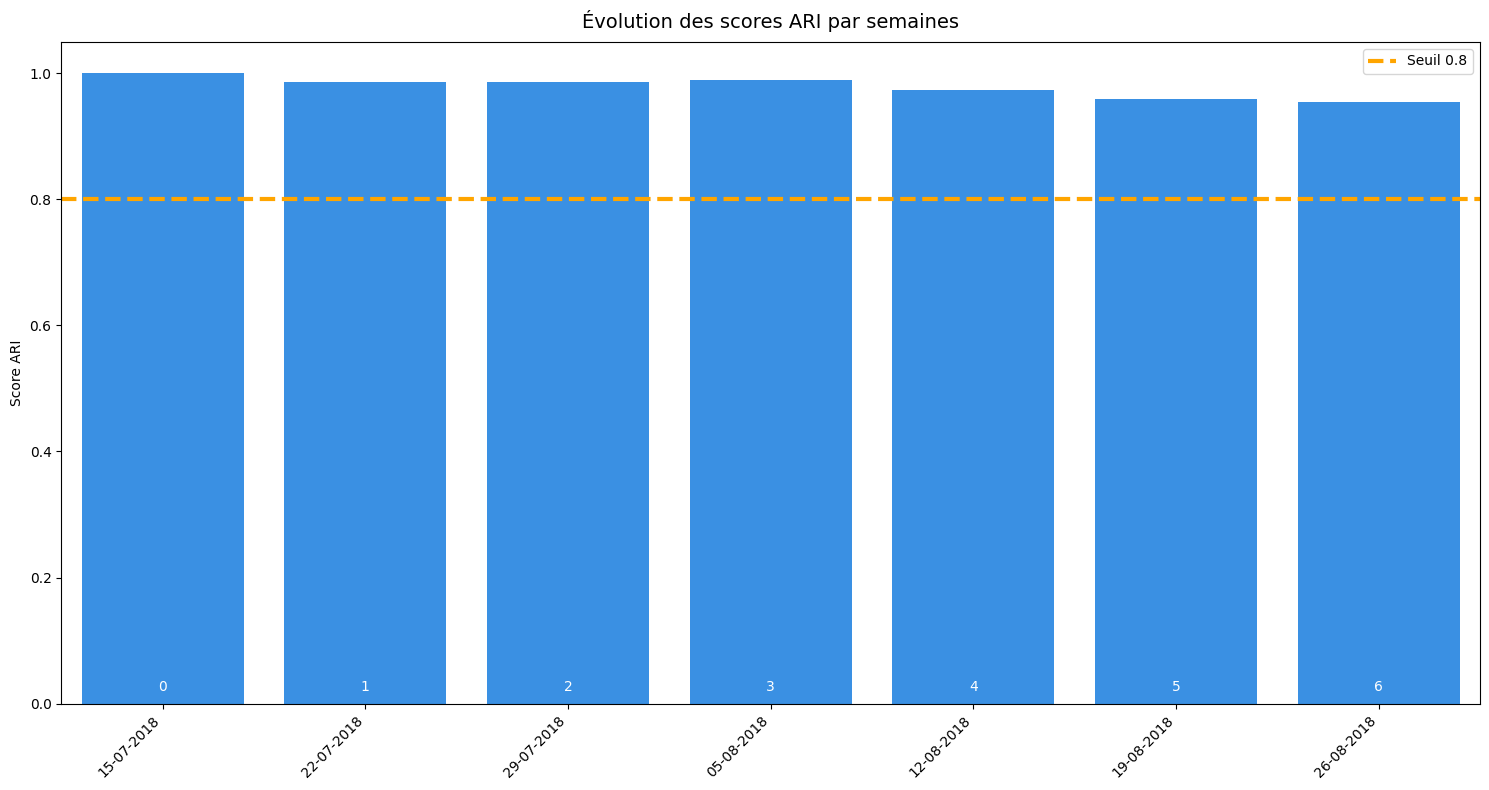

In [43]:
# Affichage d'un graphique en barres
plt.figure(figsize=(15, 8))
sns.barplot(x=df_ari_scores['Date simulation'], y=df_ari_scores['Score ARI'], color='dodgerblue')

# Ligne à 0.80
plt.axhline(y=0.8, color='orange', linestyle='--', label='Seuil 0.8', linewidth=3)
plt.xticks(rotation=45, ha='right')

# Ajout des nombres de semaines en bas des barres
for index, value in enumerate(df_ari_scores['Score ARI']):
    # plt.text(x=index, y=0.02, s=f'{len(df_ari_scores) - index}', ha='center', c='white')
    plt.text(x=index, y=0.02, s=f'{index}', ha='center', c='white')

plt.title('Évolution des scores ARI par semaines', fontsize=14, pad=10)
plt.xlabel('')
plt.ylabel('Score ARI')
plt.legend()
plt.tight_layout()

plt.show()

### 5.4.4 Conclusion

* Malgré une excellente peformance des prédictions sur les 6 dernières semaines, un modèle entraîné fin 2017 a montré une qualité de prédiction fortement dégradée au bout de 3 semaines
* Recommandation : réentraîner le modèle tous les 15 jours

# 6 Calcul des scores ARI - Version 3

* On part d'une labellisation KMeans avec des données jusqu'à D0 = 31/12/2017  
* On calcule les scores ARI entre **model_d0 / transformers d0 / données dn** et **model_dn / tranformers dn / données dn**, avec dn+1 = dn + 7 jours, de d0 = 31/12/2017 jusqu'à dn < 01/09/2018
* Dans cette version les transformers d0 sont conservés pour préparer les données dn avant prédiction  

In [44]:
# Fréquence des simulations = 7 jours
simul_frequency = pd.to_timedelta('7 days')

In [45]:
features = ['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']

## 6.1 Modèle D0 (Réel)

* On se positionne le 31/12/2017
* On entraine un modèle et on va rechercher combien de semaines ses prédictions sont fiables (score ARI > 0.8)

In [46]:
# Date D0
d0_date = pd.to_datetime('2017-12-31')

* Calcul des features RFM en fonction de la date

In [47]:
d0_RFM_features = get_RFM_features(df_features, d0_date)

* Transformations des features (classement des dépenses par tranches de montant, application et **conservation** des transformers MinMaxScaler)

In [48]:
d0_RFM_transformed_features, d0_recence_scaler, d0_montant_scaler = add_transformed_RFM_features(d0_RFM_features)

* Fit et sauvegarde du modèle KMeans

In [49]:
d0_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
d0_kmeans_fitted = d0_kmeans.fit(d0_RFM_transformed_features[features])

## 6.2 Calcul des scores ARI entre d0_kmeans.predict(d(n)_RFM_features) et d(n)_kmeans.fit(d(n)_RFM_features), avec d(n + 1) = d(n) + 7 jours 

* Boucle sur toutes les semaines suivant d0_date jusqu'au 31/08/2018 pour récupérer les labels de prédictions
* On calcule et stocke le score ARI en entre d0.predict et dn.fit

In [50]:
d_end_date = pd.to_datetime('2018-09-01')

In [51]:
# Stockage des résultats ARI
ari_scores = []

In [52]:
# Date de filtrage des données pour la première prédiction
# En fixant la première date de prédiction à la date d0, on doit trouver un score ARI de 1 pour la première prédiction
dn_date = d0_date

# Boucle jusqu'à la fin de période
while dn_date < d_end_date:
    # Calcul des features RFM en fonction de la date des données de prédiction
    dn_RFM_features = get_RFM_features(df_features, dn_date)

    # Transformation des features en utilisant les transformers d0
    dn_RFM_transformed_features, _, _ = add_transformed_RFM_features(dn_RFM_features, d0_recence_scaler, d0_montant_scaler)

    # Récupération des labels à la date dn_date
    dn_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
    dn_kmeans.fit(dn_RFM_transformed_features[features])
    dn_RFM_features['Labels dn'] = dn_kmeans.labels_
    
    #--------------------

    # Predict des labels sur les données dn_date avec le modèle entraîné en d0_date
    dn_RFM_features['Labels d0'] = d0_kmeans.predict(dn_RFM_transformed_features[features])

    # Calcul du score ARI
    ari_score = adjusted_rand_score(dn_RFM_features['Labels d0'], dn_RFM_features['Labels dn'])

    # Ajout des résultats à la listes des scores ARI
    ari_scores.append((dn_date.strftime('%d-%m-%Y'), ari_score))

    # Préparation de la simulation suivante en décalant dn_date d'1 semaine
    dn_date += simul_frequency

* Conversion en DataFrame

In [53]:
df_ari_scores = pd.DataFrame(ari_scores, columns=['Date simulation', 'Score ARI'])

* Affichage des résultats

In [54]:
display(df_ari_scores)

,Date simulation,Score ARI
0,31-12-2017,1.000000
1,07-01-2018,0.991896
2,14-01-2018,0.988122
3,21-01-2018,0.757095
4,28-01-2018,0.764628
5,04-02-2018,0.756842
6,11-02-2018,0.762808
7,18-02-2018,0.944488
8,25-02-2018,0.500742
9,04-03-2018,0.928653


* Dès la 3ème semaine le score ARI descend en dessous de 0.8

## 6.3 Visualisation

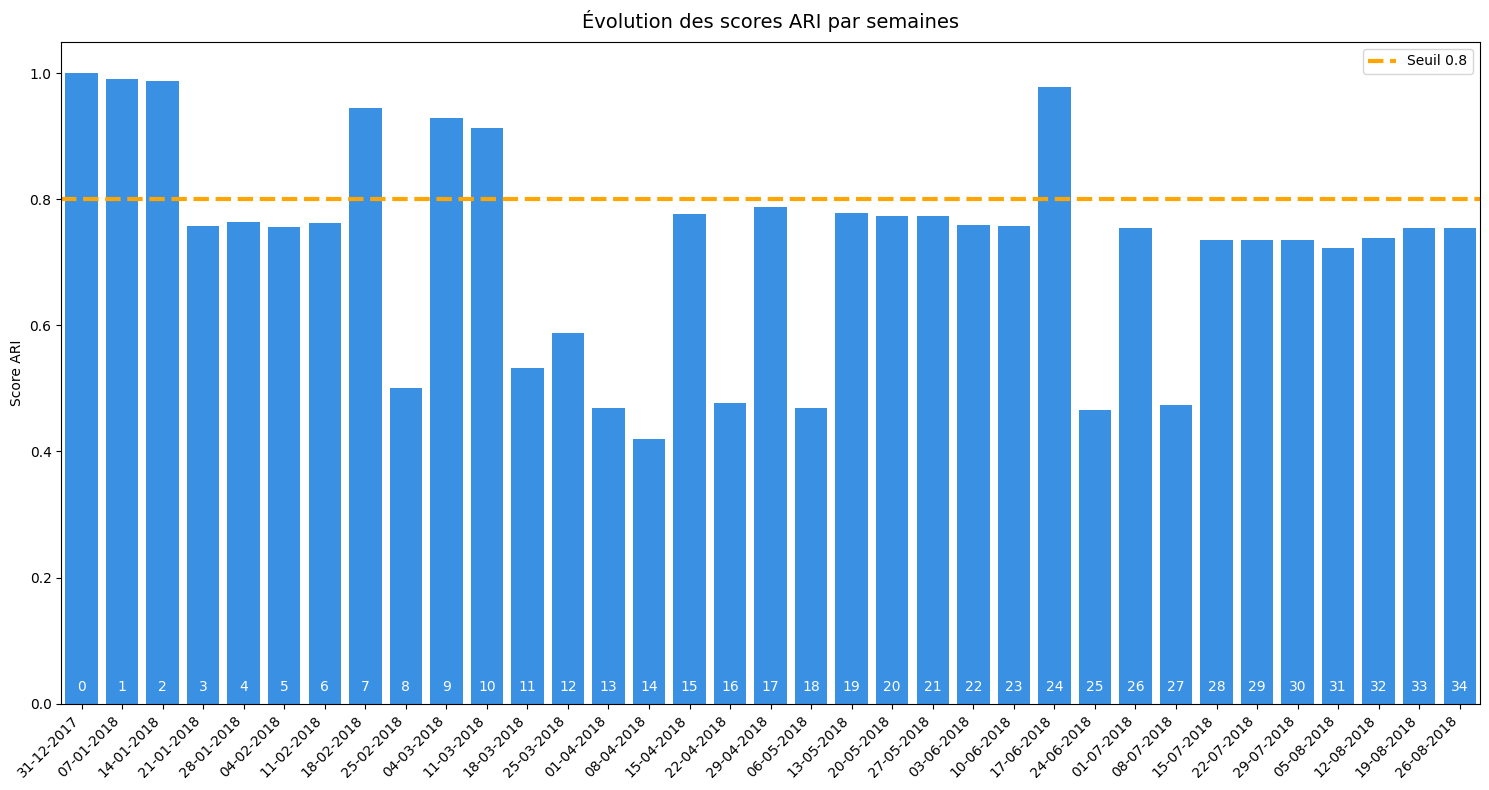

In [55]:
# Affichage d'un graphique en barres
plt.figure(figsize=(15, 8))
sns.barplot(x=df_ari_scores['Date simulation'], y=df_ari_scores['Score ARI'], color='dodgerblue')

# Ligne à 0.80
plt.axhline(y=0.8, color='orange', linestyle='--', label='Seuil 0.8', linewidth=3)
plt.xticks(rotation=45, ha='right')

# Ajout des nombres de semaines en bas des barres
for index, value in enumerate(df_ari_scores['Score ARI']):
    plt.text(x=index, y=0.02, s=f'{index}', ha='center', c='white')

plt.title('Évolution des scores ARI par semaines', fontsize=14, pad=10)
plt.xlabel('')
plt.ylabel('Score ARI')
plt.legend()
plt.tight_layout()

plt.show()

* Score ARI < 0.8 dès la 3ème semaine
* Stabilité observée entre semaine 28 et semaine 34

## 6.4 Un modèle entrainé le 15/07/2018 serait-il fiable jusqu'au 31/08/2018 ?

### 6.4.1 Préparation du modèle D0

In [56]:
# Date D0
d0_date = pd.to_datetime('2018-07-15')

In [57]:
# Calcul des features RFM à d0
d0_RFM_features = get_RFM_features(df_features, d0_date)

In [58]:
# Transformations des features avec récupération des transformers
d0_RFM_transformed_features, d0_recence_scaler, d0_montant_scaler = add_transformed_RFM_features(d0_RFM_features)

In [59]:
# Fit et sauvegarde du modèle 
d0_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
d0_kmeans_fitted = d0_kmeans.fit(d0_RFM_transformed_features[features])

### 6.4.2 Calcul des scores ARI

In [60]:
d_end_date = pd.to_datetime('2018-09-01')

In [61]:
# Stockage des résultats ARI
ari_scores = []

In [62]:
# Date de filtrage des données pour la première prédiction
# En fixant la première date de prédiction à la date d0, on doit trouver un score ARI de 1 pour la première prédiction
dn_date = d0_date

# Boucle jusqu'à la fin de période
while dn_date < d_end_date:
    # Calcul des features RFM en fonction de la date des données de prédiction
    dn_RFM_features = get_RFM_features(df_features, dn_date)

    # Transformation des features en utilisant les transformers d0
    dn_RFM_transformed_features, _, _ = add_transformed_RFM_features(dn_RFM_features, d0_recence_scaler, d0_montant_scaler)

    # Récupération des labels à la date dn_date
    dn_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
    dn_kmeans.fit(dn_RFM_transformed_features[features])
    dn_RFM_features['Labels dn'] = dn_kmeans.labels_
    
    #--------------------

    # Predict des labels sur les données dn_date avec le modèle entraîné en d0_date
    dn_RFM_features['Labels d0'] = d0_kmeans.predict(dn_RFM_transformed_features[features])

    # Calcul du score ARI
    ari_score = adjusted_rand_score(dn_RFM_features['Labels d0'], dn_RFM_features['Labels dn'])

    # Ajout des résultats à la listes des scores ARI
    ari_scores.append((dn_date.strftime('%d-%m-%Y'), ari_score))

    # Préparation de la simulation suivante en décalant dn_date d'1 semaine
    dn_date += simul_frequency

* Conversion en DataFrame

In [63]:
df_ari_scores = pd.DataFrame(ari_scores, columns=['Date simulation', 'Score ARI'])

* Affichage des résultats

In [64]:
display(df_ari_scores)

,Date simulation,Score ARI
0,15-07-2018,1.000000
1,22-07-2018,0.986575
2,29-07-2018,0.986939
3,05-08-2018,0.988861
4,12-08-2018,0.973610
5,19-08-2018,0.960012
6,26-08-2018,0.955367


* Le score ARI reste stable sur toute la période, sans descendre au dessous de 0.95

### 6.4.3 Visualisation

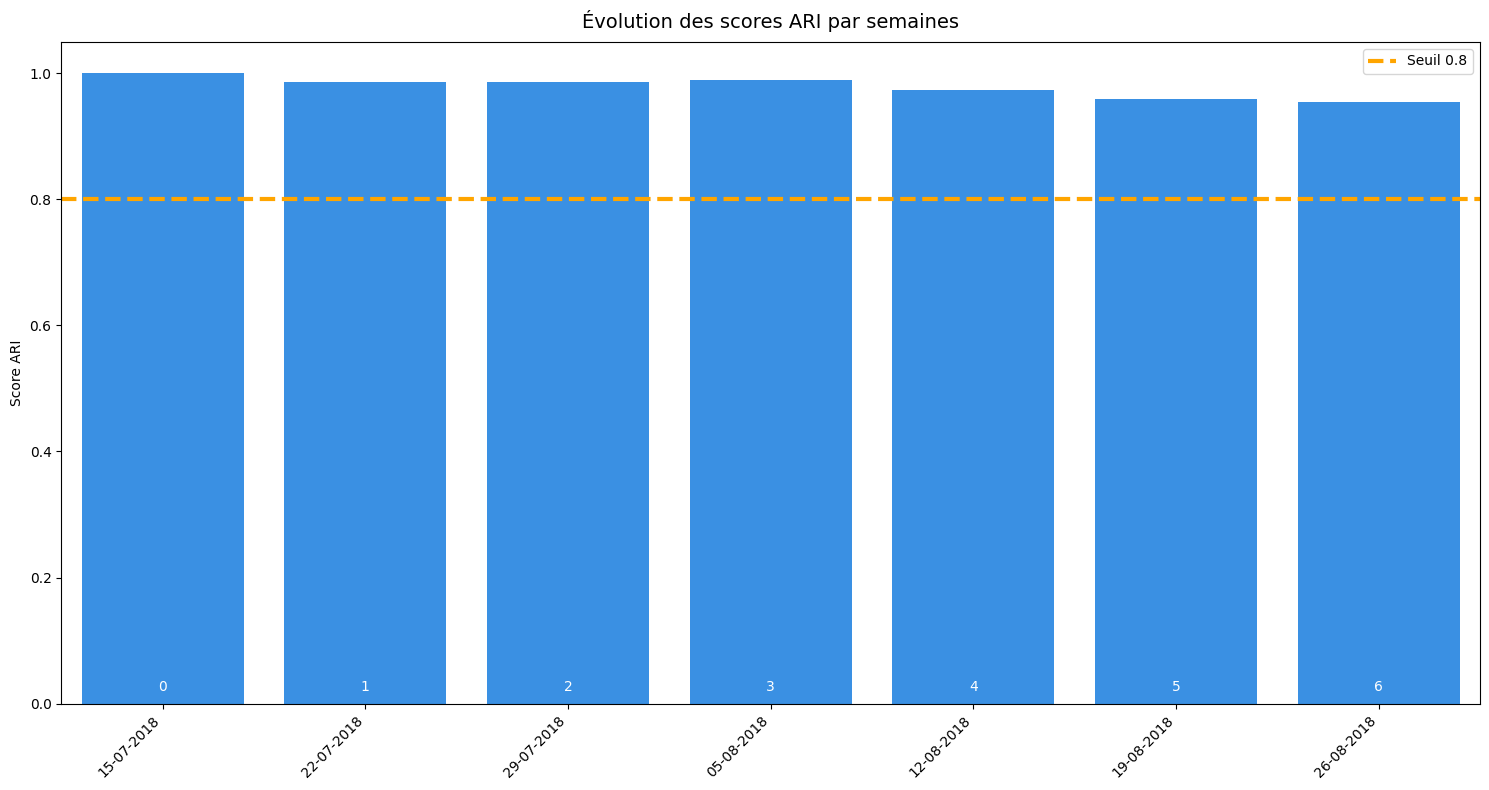

In [65]:
# Affichage d'un graphique en barres
plt.figure(figsize=(15, 8))
sns.barplot(x=df_ari_scores['Date simulation'], y=df_ari_scores['Score ARI'], color='dodgerblue')

# Ligne à 0.80
plt.axhline(y=0.8, color='orange', linestyle='--', label='Seuil 0.8', linewidth=3)
plt.xticks(rotation=45, ha='right')

# Ajout des nombres de semaines en bas des barres
for index, value in enumerate(df_ari_scores['Score ARI']):
    # plt.text(x=index, y=0.02, s=f'{len(df_ari_scores) - index}', ha='center', c='white')
    plt.text(x=index, y=0.02, s=f'{index}', ha='center', c='white')

plt.title('Évolution des scores ARI par semaines', fontsize=14, pad=10)
plt.xlabel('')
plt.ylabel('Score ARI')
plt.legend()
plt.tight_layout()

plt.show()

### 6.4.4 Conclusion

* Malgré une excellente peformance des prédictions sur les 6 dernières semaines, un modèle entraîné fin 2017 a montré une qualité de prédiction fortement dégradée au bout de 3 semaines
* Recommandation : réentraîner le modèle tous les 15 jours